# Deep Learning Template

In [17]:
#imports 
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



<h4 style="color:yellow;">Set Parameters</h4>

In [18]:
learning_rate = 0.001 
batch_size = 5
epochs = 100

# Neil - 1-5 ReLU
# Adrian - 1-5 PReLU
# Rosette - 6-10 ReLU
# Jason - 6-10 PReLU
# Pau - Identity

# uncomment the activation function you want to use
activation = nn.ReLU() # all negative values are turned to 0 (best if preprocessing include transformation to positive x values)
# activation = nn.PReLU()
# activation = nn.Identity()

Load dataset

In [19]:
x_train = pd.read_csv("./current_iteration_files/x_train.csv", index_col=0)
y_train = pd.read_csv("./current_iteration_files/y_train.csv", index_col=0)
x_test = pd.read_csv("./current_iteration_files/x_test.csv", index_col=0)
y_test = pd.read_csv("./current_iteration_files/y_test.csv", index_col=0)

if activation == nn.ReLU():

    min_max_scaler = MinMaxScaler()
    y_train_norm = min_max_scaler.fit_transform(y_train)
    y_test_norm = min_max_scaler.transform(y_test)

    x_train = torch.Tensor(x_train.values)
    y_train = torch.Tensor(y_train_norm)
    x_test = torch.Tensor(x_test.values)
    y_test = torch.Tensor(y_test_norm)

else:
    x_train = torch.Tensor(x_train.values)
    y_train = torch.Tensor(y_train.values)
    x_test = torch.Tensor(x_test.values)
    y_test = torch.Tensor(y_test.values)


In [20]:
# setting device to use (in case device you're using has GPU or MPS, use this for faster training)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using {} device".format(device))



Using cpu device


Building the neural network architecture

<h4 style="color:yellow;">Edit "multiple layers" to experiment with different architectures</h4>

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.activation = activation
        
        # feel free to add more or reduce the no of layers
        # make sure starting and ending dimensions are self.in_dim and self.out_dim
        self.multiple_layers = nn.Sequential(
            nn.Linear(self.in_dim, 10),
            self.activation,

            nn.Linear(10, 5),
            self.activation,

            nn.Linear(5, self.out_dim),
            self.activation,
        )
        
    
    def forward(self, x):
        
        y = self.multiple_layers(x)
    
        return y

In [22]:
in_dim = x_train.shape[1]
out_dim = y_train.shape[1]
print("in_dim:", in_dim, "\nout_dim:", out_dim)

in_dim: 51 
out_dim: 1


In [23]:
model = NeuralNetwork(in_dim, out_dim)

# Test structure of model
predictions = model.forward(x_train)

print(predictions.shape)
predictions

torch.Size([16297, 1])


tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], grad_fn=<ReluBackward0>)

Other parameters you can change(?)

In [24]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #optimization function
loss_fn = nn.MSELoss() # loss function

In [25]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [26]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

In [27]:

custom_dataset = MyCustomDataset(x=x_train, y=y_train)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))



Epoch: 0


100%|██████████| 3260/3260 [00:10<00:00, 299.71it/s, loss=5.43e+9] 


Ave Loss: 5042670027.8625765
Epoch: 1


100%|██████████| 3260/3260 [00:11<00:00, 277.09it/s, loss=3.54e+9] 


Ave Loss: 2000291263.1337423
Epoch: 2


100%|██████████| 3260/3260 [00:13<00:00, 237.62it/s, loss=3.45e+9] 


Ave Loss: 1829757667.379141
Epoch: 3


100%|██████████| 3260/3260 [00:12<00:00, 269.16it/s, loss=3.38e+9] 


Ave Loss: 1793518179.577914
Epoch: 4


100%|██████████| 3260/3260 [00:12<00:00, 255.08it/s, loss=3.3e+9]  


Ave Loss: 1758784981.977914
Epoch: 5


100%|██████████| 3260/3260 [00:12<00:00, 258.57it/s, loss=3.22e+9] 


Ave Loss: 1724987342.9288344
Epoch: 6


100%|██████████| 3260/3260 [00:12<00:00, 253.84it/s, loss=3.14e+9] 


Ave Loss: 1691706122.2687116
Epoch: 7


100%|██████████| 3260/3260 [00:12<00:00, 254.58it/s, loss=3.06e+9] 


Ave Loss: 1658573476.8625767
Epoch: 8


100%|██████████| 3260/3260 [00:13<00:00, 240.71it/s, loss=2.96e+9] 


Ave Loss: 1625253319.4490798
Epoch: 9


100%|██████████| 3260/3260 [00:12<00:00, 252.96it/s, loss=2.87e+9] 


Ave Loss: 1591428668.206135
Epoch: 10


100%|██████████| 3260/3260 [00:11<00:00, 273.92it/s, loss=2.77e+9] 


Ave Loss: 1556790034.6601226
Epoch: 11


100%|██████████| 3260/3260 [00:12<00:00, 265.27it/s, loss=2.66e+9] 


Ave Loss: 1521028169.8564417
Epoch: 12


100%|██████████| 3260/3260 [00:12<00:00, 265.17it/s, loss=2.54e+9] 


Ave Loss: 1483827483.201227
Epoch: 13


100%|██████████| 3260/3260 [00:12<00:00, 269.88it/s, loss=2.42e+9] 


Ave Loss: 1444862593.1116564
Epoch: 14


100%|██████████| 3260/3260 [00:12<00:00, 264.09it/s, loss=2.28e+9] 


Ave Loss: 1403796541.7263803
Epoch: 15


100%|██████████| 3260/3260 [00:12<00:00, 265.55it/s, loss=2.14e+9] 


Ave Loss: 1360282603.2993865
Epoch: 16


100%|██████████| 3260/3260 [00:12<00:00, 259.19it/s, loss=1.99e+9] 


Ave Loss: 1313980448.1067486
Epoch: 17


100%|██████████| 3260/3260 [00:12<00:00, 261.98it/s, loss=1.83e+9] 


Ave Loss: 1264568354.6944785
Epoch: 18


100%|██████████| 3260/3260 [00:13<00:00, 239.74it/s, loss=1.66e+9] 


Ave Loss: 1211814118.9496932
Epoch: 19


100%|██████████| 3260/3260 [00:12<00:00, 262.96it/s, loss=1.49e+9] 


Ave Loss: 1155590981.9484663
Epoch: 20


100%|██████████| 3260/3260 [00:13<00:00, 250.06it/s, loss=1.31e+9]


Ave Loss: 1095839629.8134968
Epoch: 21


100%|██████████| 3260/3260 [00:13<00:00, 236.18it/s, loss=1.14e+9]


Ave Loss: 1032626074.6736196
Epoch: 22


100%|██████████| 3260/3260 [00:13<00:00, 250.53it/s, loss=9.72e+8]


Ave Loss: 966180274.1239264
Epoch: 23


100%|██████████| 3260/3260 [00:12<00:00, 253.69it/s, loss=8.14e+8]


Ave Loss: 896963157.4785277
Epoch: 24


100%|██████████| 3260/3260 [00:12<00:00, 267.10it/s, loss=6.71e+8]


Ave Loss: 825821237.9883436
Epoch: 25


100%|██████████| 3260/3260 [00:11<00:00, 272.28it/s, loss=5.48e+8]


Ave Loss: 753899621.0006135
Epoch: 26


100%|██████████| 3260/3260 [00:13<00:00, 250.50it/s, loss=4.51e+8]


Ave Loss: 682511089.2361963
Epoch: 27


100%|██████████| 3260/3260 [00:12<00:00, 265.77it/s, loss=3.76e+8]


Ave Loss: 612980083.1855829
Epoch: 28


100%|██████████| 3260/3260 [00:11<00:00, 274.59it/s, loss=3.18e+8]


Ave Loss: 546534181.5113497
Epoch: 29


100%|██████████| 3260/3260 [00:11<00:00, 291.84it/s, loss=2.75e+8]


Ave Loss: 483996569.74539876
Epoch: 30


100%|██████████| 3260/3260 [00:11<00:00, 294.95it/s, loss=2.43e+8]


Ave Loss: 426162974.8269939
Epoch: 31


100%|██████████| 3260/3260 [00:11<00:00, 280.67it/s, loss=2.12e+8]


Ave Loss: 374082118.8886503
Epoch: 32


100%|██████████| 3260/3260 [00:11<00:00, 293.14it/s, loss=1.77e+8]


Ave Loss: 328377874.24708587
Epoch: 33


100%|██████████| 3260/3260 [00:11<00:00, 294.06it/s, loss=1.47e+8]


Ave Loss: 288465273.6704755
Epoch: 34


100%|██████████| 3260/3260 [00:11<00:00, 293.78it/s, loss=1.22e+8]


Ave Loss: 253578423.422546
Epoch: 35


100%|██████████| 3260/3260 [00:12<00:00, 266.64it/s, loss=1.02e+8]


Ave Loss: 222516169.3365414
Epoch: 36


100%|██████████| 3260/3260 [00:11<00:00, 291.40it/s, loss=7.69e+7]


Ave Loss: 193609021.83726993
Epoch: 37


100%|██████████| 3260/3260 [00:11<00:00, 293.07it/s, loss=5.2e+7] 


Ave Loss: 167059047.85080522
Epoch: 38


100%|██████████| 3260/3260 [00:11<00:00, 290.27it/s, loss=3.84e+7]


Ave Loss: 144721279.28773963
Epoch: 39


100%|██████████| 3260/3260 [00:10<00:00, 298.99it/s, loss=3.44e+7]


Ave Loss: 126564389.5466641
Epoch: 40


100%|██████████| 3260/3260 [00:10<00:00, 298.94it/s, loss=3.69e+7]


Ave Loss: 111756931.92039877
Epoch: 41


100%|██████████| 3260/3260 [00:11<00:00, 287.53it/s, loss=4.29e+7]


Ave Loss: 99559136.95283742
Epoch: 42


100%|██████████| 3260/3260 [00:10<00:00, 297.79it/s, loss=5.04e+7]


Ave Loss: 89511877.9228288
Epoch: 43


100%|██████████| 3260/3260 [00:11<00:00, 279.11it/s, loss=5.55e+7]


Ave Loss: 81259540.76629601
Epoch: 44


100%|██████████| 3260/3260 [00:11<00:00, 280.27it/s, loss=5.95e+7]


Ave Loss: 74433841.70600076
Epoch: 45


100%|██████████| 3260/3260 [00:12<00:00, 252.92it/s, loss=6.26e+7]


Ave Loss: 68708192.65001917
Epoch: 46


100%|██████████| 3260/3260 [00:13<00:00, 248.12it/s, loss=6.39e+7]


Ave Loss: 63847017.158109665
Epoch: 47


100%|██████████| 3260/3260 [00:12<00:00, 254.48it/s, loss=6.29e+7]


Ave Loss: 59607533.87502876
Epoch: 48


100%|██████████| 3260/3260 [00:12<00:00, 254.11it/s, loss=6.07e+7]


Ave Loss: 55752738.12143405
Epoch: 49


100%|██████████| 3260/3260 [00:14<00:00, 226.95it/s, loss=5.98e+7]


Ave Loss: 52283710.67615031
Epoch: 50


100%|██████████| 3260/3260 [00:27<00:00, 119.81it/s, loss=6.16e+7]


Ave Loss: 49354663.49628068
Epoch: 51


100%|██████████| 3260/3260 [00:26<00:00, 123.19it/s, loss=6.47e+7]


Ave Loss: 46936626.71199195
Epoch: 52


100%|██████████| 3260/3260 [00:25<00:00, 126.78it/s, loss=6.8e+7] 


Ave Loss: 44870781.05586656
Epoch: 53


100%|██████████| 3260/3260 [00:18<00:00, 177.55it/s, loss=7.13e+7]


Ave Loss: 43081264.59415261
Epoch: 54


100%|██████████| 3260/3260 [00:10<00:00, 305.54it/s, loss=7.46e+7]


Ave Loss: 41499003.247910276
Epoch: 55


100%|██████████| 3260/3260 [00:10<00:00, 301.47it/s, loss=7.7e+7] 


Ave Loss: 40087938.99520706
Epoch: 56


100%|██████████| 3260/3260 [00:11<00:00, 284.77it/s, loss=7.88e+7]


Ave Loss: 38832159.71480061
Epoch: 57


100%|██████████| 3260/3260 [00:13<00:00, 250.39it/s, loss=8.06e+7]


Ave Loss: 37706922.09521664
Epoch: 58


100%|██████████| 3260/3260 [00:13<00:00, 247.98it/s, loss=8.21e+7]


Ave Loss: 36681489.84920437
Epoch: 59


100%|██████████| 3260/3260 [00:15<00:00, 215.13it/s, loss=8.26e+7]


Ave Loss: 35752267.09357745
Epoch: 60


100%|██████████| 3260/3260 [00:16<00:00, 198.06it/s, loss=8.07e+7]


Ave Loss: 34900185.133224696
Epoch: 61


100%|██████████| 3260/3260 [00:16<00:00, 198.79it/s, loss=7.85e+7]


Ave Loss: 34118325.92600652
Epoch: 62


100%|██████████| 3260/3260 [00:16<00:00, 203.49it/s, loss=7.59e+7]


Ave Loss: 33402132.343495972
Epoch: 63


100%|██████████| 3260/3260 [00:16<00:00, 201.46it/s, loss=7.36e+7]


Ave Loss: 32739810.124817867
Epoch: 64


100%|██████████| 3260/3260 [00:16<00:00, 195.57it/s, loss=7.08e+7]


Ave Loss: 32129993.9972153
Epoch: 65


100%|██████████| 3260/3260 [00:16<00:00, 199.12it/s, loss=6.92e+7]


Ave Loss: 31569946.291736964
Epoch: 66


100%|██████████| 3260/3260 [00:11<00:00, 279.76it/s, loss=6.75e+7]


Ave Loss: 31057088.534183282
Epoch: 67


100%|██████████| 3260/3260 [00:13<00:00, 248.83it/s, loss=6.47e+7]


Ave Loss: 30590388.197018787
Epoch: 68


100%|██████████| 3260/3260 [00:17<00:00, 189.54it/s, loss=6.28e+7]


Ave Loss: 30171034.70261695
Epoch: 69


100%|██████████| 3260/3260 [00:17<00:00, 191.50it/s, loss=5.99e+7]


Ave Loss: 29784271.34430119
Epoch: 70


100%|██████████| 3260/3260 [00:16<00:00, 194.84it/s, loss=5.84e+7]


Ave Loss: 29426363.658176765
Epoch: 71


100%|██████████| 3260/3260 [00:11<00:00, 284.66it/s, loss=5.74e+7]


Ave Loss: 29100751.33033934
Epoch: 72


100%|██████████| 3260/3260 [00:11<00:00, 278.34it/s, loss=5.63e+7]


Ave Loss: 28795895.36706288
Epoch: 73


100%|██████████| 3260/3260 [00:11<00:00, 287.64it/s, loss=5.62e+7]


Ave Loss: 28516011.861320935
Epoch: 74


100%|██████████| 3260/3260 [00:11<00:00, 272.26it/s, loss=5.54e+7]


Ave Loss: 28263078.60470667
Epoch: 75


100%|██████████| 3260/3260 [00:12<00:00, 269.43it/s, loss=5.42e+7]


Ave Loss: 28024249.77175997
Epoch: 76


100%|██████████| 3260/3260 [00:12<00:00, 263.69it/s, loss=5.38e+7]


Ave Loss: 27799794.267360047
Epoch: 77


100%|██████████| 3260/3260 [00:11<00:00, 275.41it/s, loss=5.34e+7]


Ave Loss: 27596165.719066333
Epoch: 78


100%|██████████| 3260/3260 [00:12<00:00, 266.33it/s, loss=5.38e+7]


Ave Loss: 27403451.6570648
Epoch: 79


100%|██████████| 3260/3260 [00:11<00:00, 273.14it/s, loss=5.22e+7]


Ave Loss: 27225062.165193636
Epoch: 80


100%|██████████| 3260/3260 [00:12<00:00, 267.34it/s, loss=5.06e+7]


Ave Loss: 27055291.999482363
Epoch: 81


100%|██████████| 3260/3260 [00:12<00:00, 269.15it/s, loss=4.96e+7]


Ave Loss: 26892082.558378067
Epoch: 82


100%|██████████| 3260/3260 [00:12<00:00, 265.65it/s, loss=4.87e+7]


Ave Loss: 26745579.556326687
Epoch: 83


100%|██████████| 3260/3260 [00:12<00:00, 259.19it/s, loss=4.79e+7]


Ave Loss: 26606496.10532017
Epoch: 84


100%|██████████| 3260/3260 [00:12<00:00, 268.17it/s, loss=4.63e+7]


Ave Loss: 26473167.011512652
Epoch: 85


100%|██████████| 3260/3260 [00:12<00:00, 250.93it/s, loss=4.72e+7]


Ave Loss: 26345033.859144937
Epoch: 86


100%|██████████| 3260/3260 [00:12<00:00, 265.31it/s, loss=4.76e+7]


Ave Loss: 26221798.577789493
Epoch: 87


100%|██████████| 3260/3260 [00:12<00:00, 259.58it/s, loss=4.77e+7]


Ave Loss: 26106891.633828603
Epoch: 88


100%|██████████| 3260/3260 [00:12<00:00, 253.27it/s, loss=4.78e+7]


Ave Loss: 26004046.840883818
Epoch: 89


100%|██████████| 3260/3260 [00:12<00:00, 253.63it/s, loss=4.73e+7]


Ave Loss: 25908107.064723928
Epoch: 90


100%|██████████| 3260/3260 [00:12<00:00, 269.56it/s, loss=4.68e+7]


Ave Loss: 25813851.321251918
Epoch: 91


100%|██████████| 3260/3260 [00:12<00:00, 268.20it/s, loss=4.68e+7]


Ave Loss: 25720159.949942484
Epoch: 92


100%|██████████| 3260/3260 [00:11<00:00, 276.88it/s, loss=4.63e+7]


Ave Loss: 25634762.24039494
Epoch: 93


100%|██████████| 3260/3260 [00:12<00:00, 250.96it/s, loss=4.66e+7]


Ave Loss: 25557361.489148773
Epoch: 94


100%|██████████| 3260/3260 [00:13<00:00, 244.27it/s, loss=4.65e+7]


Ave Loss: 25478525.167638037
Epoch: 95


100%|██████████| 3260/3260 [00:13<00:00, 243.87it/s, loss=4.62e+7]


Ave Loss: 25405783.86203029
Epoch: 96


100%|██████████| 3260/3260 [00:12<00:00, 252.88it/s, loss=4.65e+7]


Ave Loss: 25336798.464330904
Epoch: 97


100%|██████████| 3260/3260 [00:13<00:00, 241.23it/s, loss=4.62e+7]


Ave Loss: 25275065.121414877
Epoch: 98


100%|██████████| 3260/3260 [00:13<00:00, 239.40it/s, loss=4.67e+7]


Ave Loss: 25216377.665116947
Epoch: 99


100%|██████████| 3260/3260 [00:12<00:00, 255.62it/s, loss=4.7e+7] 

Ave Loss: 25158390.21105253


Results

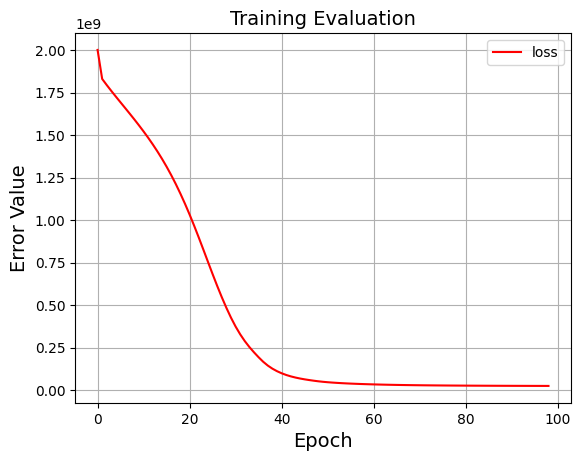

In [28]:
plt.plot(losses[1:], label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [29]:
predictions = model.forward(x_train).detach().numpy()

print("Metrics for training set:")

if activation == nn.ReLU():
    print("r2:", r2_score(min_max_scaler.inverse_transform(y_train), min_max_scaler.inverse_transform(predictions)))
    print("rmse:", mean_squared_error(min_max_scaler.inverse_transform(y_train), min_max_scaler.inverse_transform(predictions), squared=False))
else:
    print("r2:", r2_score(y_train, predictions))
    print("rmse:", mean_squared_error(y_train, predictions, squared=False))



Metrics for training set:
r2: 0.9874740819214853
rmse: 4968.1216


In [30]:
predictions = model.forward(x_test).detach().numpy()

print("Metrics for testing set:")

if activation == nn.ReLU():
    model_r2 = r2_score(min_max_scaler.inverse_transform(y_test), min_max_scaler.inverse_transform(predictions))
    print("r2:", model_r2)
    print("rmse:", mean_squared_error(min_max_scaler.inverse_transform(y_test), min_max_scaler.inverse_transform(predictions), squared=False))
else:
    model_r2 = r2_score(y_test, predictions)
    print("r2:", model_r2)
    print("rmse:", mean_squared_error(y_test, predictions, squared=False))

Metrics for testing set:
r2: 0.985318622860009
rmse: 5416.4136


Save iteration

In [31]:
dl_steps = {"learning_rate":learning_rate, "batch_size":batch_size, "epochs":epochs,"layers":model.multiple_layers, "best_r2":model_r2}

ml = pd.json_normalize(dl_steps)


with open("./current_iteration_files/preprocessing.json", "r") as outfile: 
    preprocessing_steps = json.load(outfile, )

preprocessing = pd.json_normalize(preprocessing_steps)

all_process = pd.concat([preprocessing, ml], axis=1)
pd.set_option("display.max_colwidth", None)


In [32]:
try:
    iterations = pd.read_csv("./tested_iterations.csv", dtype=str)
    new_iterations = pd.concat([iterations,all_process.astype(str)], ignore_index=True, axis=0)
    if new_iterations.duplicated().sum() != 0:
        print("Current steps are duplicate of previous iteration. Current iteration will not be saved in the file.")
    else:
        new_iterations.to_csv("./tested_iterations.csv", index=False)

except:
    all_process.to_csv("./tested_iterations.csv", index=False)